# IS620 Final Project

### Authors 

Alex Satz, Max Wagner, Burton Machado, Lara Burford, and Riguel Fabre

### Data 

Roughly 4200 PubChem journal publications, including author affiliations. The affiliations are not provided in a specified manner and are instead listed as long 'strings' of information. 

### Goal

To create a machine learning algorithm that can pull insitution names from the affiliation data, so that a graph of schools that publish together can be formed. The difficulty is mainly the format of the affiliation strings, as they have no obvious regular expression format.

### Results 

A decision tree was found to be most applicable.  The accuracy was ~92% with the test set using the Bayes classifier and ~96% using the decision tree classifier.  However, this only tells part of the story.  We labeled a training set of ~4000 samples, and some of these we mislabeled.  Thus, the machine learning had to properly assign labels that were put in incorrectly!

In [1]:
%matplotlib inline
import random
import nltk
import string
import networkx as nx
import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Here we open a file of downloaded journal articles including author names and affiliations.

In [2]:
pubs = []
with open('project2pubs.txt','r') as f:
    for line in f:
        pubs.append(line.split(']]'))

### As you can see, the data is a mess.

In [3]:
pubs[0]

["[['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'",
 ',Key Laboratory of Stem Cell Biology, Institute of Health Sciences, Shanghai Institutes for Biological Sciences &Shanghai Jiao Tong University School of Medicine (SJTUSM), Chinese Academy of Sciences, Shanghai, China. Key Laboratory of Stem Cell Biology, Institute of Health Sciences, Shanghai Institutes for Biological Sciences &Shanghai Jiao Tong University School of Medicine (SJTUSM), Chinese Academy of Sciences, Shanghai, China. Key Laboratory of Stem Cell Biology, Institute of Health Sciences, Shanghai Institutes for Biological Sciences &Shanghai Jiao Tong University School of Medicine (SJTUSM), Chinese Academy o

### The form of the strings in the files are a mess, and much effort is needed to clean it all up.

In [4]:
stringIn = "string.with.punctuation!"

author = []
for x in pubs:
    if isinstance(x, list):
        t = (x[0].translate(None, '!@#$][,').split("'"))
        temp = []
        for x in t: 
            if x:
                if x != " ":
                    if x not in temp:
                       temp.append(x)
        author.append(temp) 
    
author[0]

['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X']

### Make sure the author and pubs were split correctly

In [5]:
len(author)

4215

In [6]:
len(pubs)

4215

### The affiliation data is a mess.  Sometimes it is delimited with a period or semicolon, etc.  Here we split up each affiliation using a number of delimiters.

In [7]:
splitcomma = []
splitperiod = []
splitsemicolon = []
splitspace = []
for x in pubs:
    if len(x) > 1:
        s = x[1]
        s = s[:-1]
        t = s.split(",")
        if len(t)>2:
            t = t[:-2]  # remove journal names
        else:
            t = " "
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitcomma.append(t)
        t = s.split(".")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitperiod.append(t)
        t = s.split(";")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitsemicolon.append(t)
        t = s.split(" ")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitspace.append(t)
    else:
        splitcomma.append("")
        splitperiod.append("")
        splitsemicolon.append("")
        splitspace.append("")

In [8]:
def stringHasPunct(s):
    if not s:
        return True
    for x in string.punctuation:
        if x in s:
            return True
    return False

### Below we generate a list of all possible 'phrases' in the affiliation.

In [9]:
listterms = []
for x in range(0, len(splitcomma)):
    temp = []
    t = []
    for y in splitcomma[x]:
        if not stringHasPunct(y):
            t.append(y)
    temp.append(t)
    t = []
    for y in splitsemicolon[x]:
        if not stringHasPunct(y):
            t.append(y)
    temp.append(t)
    t = []
    for y in splitperiod[x]:
        if not stringHasPunct(y):
            t.append(y)
    temp.append(t)
    listterms.append(temp)

### Example affiliations are shown below.  The question is, can a machine learning classification determine which are institution names?

In [10]:
listterms[2]

[['Qinghai Provincial Key Laboratory for Plague Control and Research',
  'Qinghai Institute for Endemic Disease Prevention and Control',
  'Xining',
  'Qinghai Province',
  '811602',
  'Fengtai',
  'Beijing',
  '100071',
  'Qinghai Institute for Endemic Disease Prevention and Control',
  'Xining',
  'Qinghai Province',
  '811602',
  'Fengtai',
  'Beijing',
  '100071'],
 [],
 ['com']]

### Here all the phrases are saved to a csv.  Some of the phrases are labeled in the csv file in order to train the system.

In [11]:
f = open('labelAffiliations.txt','w')
for x in listterms:
    for y in x:
        for z in y:
            f.write(str(z) + '\n') 
f.close() 

### In excel, >4000 'phrases' were marked as belonging to an institution or not.  Most of these were just zip codes and such, so easy to mark.

In [12]:
phrase = []
label = []
with open('labelAffiliations.csv') as f:
    for line in f:
        line = line.rstrip()
        line = line.split(",")
        if len(line) >1 and line[1]:
            phrase.append(line[0])
            label.append(line[1])      

In [13]:
len(label)

4866

### Here we get all words used in any labeled affiliation.

In [14]:
words = []
for x in phrase:
    x = x.split(" ")
    for y in x:
        words.append(y)

In [15]:
len(words)

15304

### Here we look at the top 50 words.

In [16]:
all_words = nltk.FreqDist(words)
top100 = all_words.most_common(50)

In [17]:
word_feature = []
for x in top100:
    word_feature.append(x[0])

In [18]:
word_feature

['of',
 'and',
 'Department',
 'for',
 'Center',
 'Biology',
 'University',
 'Institute',
 'Research',
 'Sciences',
 'Medicine',
 'Division',
 'Science',
 'Molecular',
 'Cell',
 'Medical',
 'Centre',
 'College',
 'Cancer',
 'Street',
 'de',
 'Genetics',
 'Laboratory',
 'Road',
 'Engineering',
 'Avenue',
 'National',
 'in',
 'Beijing',
 'Microbiology',
 'Technology',
 'New',
 'Health',
 'Biological',
 'Biotechnology',
 'Drive',
 'School',
 'China',
 'CA',
 'Cambridge',
 'Biochemistry',
 'Biol',
 'a',
 'the',
 'York',
 'Life',
 'Diseases',
 'California',
 '1',
 'Biomedical']

In [19]:
listterms[0]

[['Key Laboratory of Stem Cell Biology',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'University of California at San Diego',
  'La Jolla',
  'La Jolla',
  'California',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'Shanghai Jiao Tong University School of Medicine',
  'Shanghai'],
 [],
 []]

### Here we define the features we want to look at.  

In [20]:
def getContentIndex(listterms_x, phrase):
    '''What affiliation does a phrase occur in bearing in mind that the 
    phrases were labeled free of any context?  Now we need to figure out 
    which affiliation each phrase came from.'''
    for x in listterms_x: ## x is a list ['ewfew', 'wefew' ]
        if phrase in x:
            return x.index(phrase), x
    else:
        return False, False

def hasNumber(word):
    for x in word:
        if is_number(x):
            return True
    return False

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def firstWordisCapital(x):
    fl = x[0]
    if is_number(fl):
        return False
    if fl == fl.upper():
        return True
    return False

def ratioOfCaptialLetters(phrase):
    p = phrase.split()
    c = 0
    for x in p:
        for y in x:
            if not is_number(y):
                if y == y.upper():
                    c += 1
    if len(p) != 0:
        r = c/float(len(p))
    else:
        r = 0
    return int(r*10)

def numberOfWords(phrase):
    p = phrase.split()
    return int(len(p)/2)

def oneWord(phrase):
    p = phrase.split()
    if len(p) == 1:
        return True
    else:
        return False
    
def totalLen(phrase):
    return int(len(phrase)/10)

In [21]:
for word in word_feature:
        (word in set())

In [22]:
def document_features_old(context, phrase, word_feature):
    doci, i = getContentIndex(context, phrase)
    
    context = context[i]
    document_words = set(phrase.split())
    features = {}
    
    for word in word_feature:
        features['contains(%s)' % word] = (word in document_words)
    features['isnumeric'] = is_number(phrase)
    features['hasANumberInIt'] = hasNumber(phrase)
    features['firstLetterCapital'] = firstWordisCapital(phrase)
    features['ratioOfCaptialLetters'] = ratioOfCaptialLetters(phrase)
    features['numberOfWords'] = numberOfWords(phrase)
    features['startsWithNumber'] = is_number(phrase[0])
    features['totalLength'] = totalLen(phrase)
    features['oneWord'] = oneWord(phrase)
    
    if doci != 0:
        phrasebefore = context[doci-1]
        document_words = set(phrasebefore)
        features['isnumericBefore'] = is_number(phrasebefore)
        features['hasANumberInItBefore'] = hasNumber(phrasebefore)
        features['firstLetterCapitalBefore'] = firstWordisCapital(phrasebefore)
        features['ratioOfCaptialLettersBefore'] = ratioOfCaptialLetters(phrasebefore)
        features['numberOfWordsBefore'] = numberOfWords(phrasebefore)
        features['startsWithNumberBefore'] = is_number(phrasebefore[0])
        features['totalLengthBefore'] = totalLen(phrasebefore)
        features['oneWordBefore'] = oneWord(phrasebefore)   
    
    if doci + 1 < len(context):
        phraseafter = context[doci+1]
        document_words = set(phraseafter)
        features['isnumericAfter'] = is_number(phraseafter)
        features['hasANumberInItAfter'] = hasNumber(phraseafter)
        features['firstLetterCapitalAfter'] = firstWordisCapital(phraseafter)
        features['ratioOfCaptialLettersAfter'] = ratioOfCaptialLetters(phraseafter)
        features['numberOfWordsAfter'] = numberOfWords(phraseafter)
        features['startsWithNumberAfter'] = is_number(phraseafter[0])
        features['totalLengthAfter'] = totalLen(phraseafter)
        features['oneWordAfter'] = oneWord(phraseafter)
        
    if doci + 2 < len(context):
        phraseafter = context[doci+2]
        document_words = set(phraseafter)
        features['isnumericAfter2'] = is_number(phraseafter)
        features['hasANumberInItAfter2'] = hasNumber(phraseafter)
        features['firstLetterCapitalAfter2'] = firstWordisCapital(phraseafter)
        features['ratioOfCaptialLettersAfter2'] = ratioOfCaptialLetters(phraseafter)
        features['numberOfWordsAfter2'] = numberOfWords(phrase)
        features['totalLengthAfter2'] = totalLen(phraseafter)
        features['oneWordAfter2'] = oneWord(phraseafter)
        
    if doci + 3 < len(context):
        phraseafter = context[doci+3]
        document_words = set(phraseafter)
        features['isnumericAfter3'] = is_number(phraseafter)
        features['hasANumberInItAfter3'] = hasNumber(phraseafter)
        features['firstLetterCapitalAfter3'] = firstWordisCapital(phraseafter)
        features['ratioOfCaptialLettersAfter3'] = ratioOfCaptialLetters(phraseafter)
        features['numberOfWordsAfter3'] = numberOfWords(phraseafter)
        features['totalLengthAfter3'] = totalLen(phraseafter)
        
    return features

In [23]:
def document_features(context, phrase, word_feature):
    ## context is the 'listterms' which is a list of 3 lists

    doci, context = getContentIndex(context, phrase)
    document_words = set(phrase.split())
    features = {}
    for word in word_feature:
        features['contains(%s)' % word] = (word in document_words)
    features['isnumeric'] = is_number(phrase)
    features['hasANumberInIt'] = hasNumber(phrase)
    features['firstLetterCapital'] = firstWordisCapital(phrase)
    features['ratioOfCaptialLetters'] = ratioOfCaptialLetters(phrase)
    features['numberOfWords'] = numberOfWords(phrase)
    features['startsWithNumber'] = is_number(phrase[0])
    features['totalLength'] = totalLen(phrase)
    features['oneWord'] = oneWord(phrase)
    
    if doci != 0:
        phrasebefore = context[doci-1]
        document_words = set(phrasebefore.split())
        features['isnumericBefore'] = is_number(phrasebefore)
        features['hasANumberInItBefore'] = hasNumber(phrasebefore)
        features['firstLetterCapitalBefore'] = firstWordisCapital(phrasebefore)
        features['ratioOfCaptialLettersBefore'] = ratioOfCaptialLetters(phrasebefore)
        features['numberOfWordsBefore'] = numberOfWords(phrasebefore)
        features['startsWithNumberBefore'] = is_number(phrasebefore[0])
        features['totalLengthBefore'] = totalLen(phrasebefore)
        features['oneWordBefore'] = oneWord(phrasebefore)
        
    if doci + 1 < len(context):
        phraseafter = context[doci+1]
        document_words = set(phraseafter.split())
        features['isnumericAfter'] = is_number(phraseafter)
        features['hasANumberInItAfter'] = hasNumber(phraseafter)
        features['firstLetterCapitalAfter'] = firstWordisCapital(phraseafter)
        features['ratioOfCaptialLettersAfter'] = ratioOfCaptialLetters(phraseafter)
        features['numberOfWordsAfter'] = numberOfWords(phraseafter)
        features['startsWithNumberAfter'] = is_number(phraseafter[0])
        features['totalLengthAfter'] = totalLen(phraseafter)
        features['oneWordAfter'] = oneWord(phraseafter)
        
    return features

In [24]:
def document_features(context, phrase, word_feature):
    ## context is the 'listterms' which is a list of 3 lists

    document_words = set(phrase.split())
    features = {}
    for word in word_feature:
        features['contains(%s)' % word] = (word in document_words)
    features['isnumeric'] = is_number(phrase)
    features['hasANumberInIt'] = hasNumber(phrase)
    features['firstLetterCapital'] = firstWordisCapital(phrase)
    features['ratioOfCaptialLetters'] = ratioOfCaptialLetters(phrase)
    features['numberOfWords'] = numberOfWords(phrase)
    features['startsWithNumber'] = is_number(phrase[0])
    features['totalLength'] = totalLen(phrase)
    features['oneWord'] = oneWord(phrase)
    return features

In [25]:
d_phrases = {}
for x in range(0, len(phrase)):
    d_phrases[phrase[x]] = label[x]

In [26]:
random.shuffle(listterms)
len(d_phrases)

4177

In [27]:
listterms[0] ## each list has 3 lists (split by comma, semicolon, etc...)

[['Division of Basic Medical Science and Molecular Medicine',
  'Tokai University School of Medicine',
  '143 Shimokasuya',
  'Isehara',
  'Tokyo University of Agriculture',
  '196 Yasaka',
  'Abashiri',
  'Hokkaido',
  'Department of Genetics',
  'Cell Biology and Anatomy',
  'University of Nebraska Medical Center',
  'Omaha',
  'NE',
  '68198',
  'Tokyo University of Agriculture',
  '196 Yasaka',
  'Abashiri',
  'Hokkaido',
  'Division of Basic Medical Science and Molecular Medicine',
  'Tokai University School of Medicine',
  '143 Shimokasuya',
  'Isehara',
  'Frontier Science Research Center',
  'Kagoshima University',
  'Kagoshima',
  'Division of Basic Medical Science and Molecular Medicine',
  'Tokai University School of Medicine',
  '143 Shimokasuya',
  'Isehara'],
 [],
 []]

In [28]:
featuresets = []
phrasesLookedUp = []
for x in listterms:
    for y in x:
        for z in y:
            if z in d_phrases:
                featuresets.append([document_features(x, z, word_feature), d_phrases[z]]) 
                phrasesLookedUp.append(z)

### Here we train using a Bayes classifier and check the accuracy.

In [29]:
train_set, test_set = featuresets[2500:], featuresets[:2500]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [30]:
print nltk.classify.accuracy(classifier, test_set)

0.9192


### About 92% of the test set are not institution names.  At first this seems like bad news, but look at the errors below.

In [31]:
c = 0
for x in test_set:
    if x[1] == 's':
        c += 1
1-float(c)/len(test_set)

0.9004

In [32]:
classifier.show_most_informative_features(30)

Most Informative Features
   ratioOfCaptialLetters = 6                   g : s      =     75.8 : 1.0
       contains(Biology) = True                g : s      =     60.8 : 1.0
      contains(Sciences) = True                g : s      =     57.8 : 1.0
    contains(Technology) = True                s : g      =     35.4 : 1.0
    contains(University) = True                s : g      =     23.3 : 1.0
           numberOfWords = 4                   g : s      =     21.6 : 1.0
             totalLength = 6                   g : s      =     17.4 : 1.0
   ratioOfCaptialLetters = 17                  s : g      =     15.6 : 1.0
           contains(for) = True                g : s      =     13.0 : 1.0
        contains(School) = True                s : g      =     12.4 : 1.0
        contains(Health) = True                s : g      =     11.7 : 1.0
          contains(Life) = True                g : s      =     11.2 : 1.0
      contains(Research) = True                g : s      =     10.4 : 1.0

In [33]:
errors = []
i = 0
for (name, tag) in test_set:
    guess = classifier.classify(name)
    phrase1 = phrasesLookedUp[i]
    if guess != tag:
        errors.append( (tag, guess, phrase1) )
    i += 1

### The main errors appear to be mis-labeled as instituions by hand, but the classifier has correctly labeled them.  However, the classifier likes to label cities as schools, despite their being a single word.

In [34]:
list(set(errors))

[('g', 's', 'China National Rice Research Institute'),
 ('g', 's', 'New Jersey Medical School'),
 ('g', 's', 'College of Veterinary Medicine'),
 ('s', 'g', 'Cidade Universitaria'),
 ('g', 's', 'Charite Medical University Berlin'),
 ('g', 's', 'Charite Universitatsmedizin Berlin'),
 ('g', 's', 'Broad Institute of MIT and Harvard'),
 ('g', 's', 'Cold Spring Harbor Laboratory'),
 ('g', 's', 'Anhui University'),
 ('g', 's', 'Bioscience Institute'),
 ('g', 's', 'Biosignal Genome Resource Center'),
 ('g', 's', 'Agricultural Technology Research Institute'),
 ('g', 's', 'Bioanalytical Mass Spectrometry'),
 ('s', 'g', 'Berkeley'),
 ('g', 's', 'Beth Israel Deaconess Medical Center'),
 ('g', 's', 'National Institute of Chemistry'),
 ('g', 's', 'Center for Public Health Genomics'),
 ('g', 's', 'Center for Reproductive Medicine'),
 ('g', 's', 'Dalhousie University'),
 ('g', 's', 'Eastern Virginia Medical School'),
 ('g', 's', 'Academic Medical Center'),
 ('g', 's', 'Baylor College of Medicine'),
 (

### Here we check to see what is marked as an institution.

In [35]:
sguess = []
i = 0
for (name, tag) in test_set:
    guess = classifier.classify(name)
    phrase2 = phrasesLookedUp[i]
    if tag == 's':
        sguess.append( (tag, guess, phrase2) )
    i += 1

### Lets see how a decision tree classifier performs.

In [36]:
classifier_dt = nltk.classify.DecisionTreeClassifier.train(train_set)

### This error rate looks a bit better than for the Bayes.

In [37]:
print nltk.classify.accuracy(classifier_dt, test_set)

0.9572


### There are a lot of reasonable corrections to the assignments, so the classifier is doing a better job.  Plus, there are no cities being named as institutions.  

In [38]:
errors = []
i = 0
for (name, tag) in test_set:
    guess = classifier.classify(name)
    phrase3 = phrasesLookedUp[i]
    if guess != tag:
        errors.append( (tag, guess, phrase3) )
    i += 1

list(set(errors))

[('g', 's', 'China National Rice Research Institute'),
 ('g', 's', 'New Jersey Medical School'),
 ('g', 's', 'College of Veterinary Medicine'),
 ('s', 'g', 'Cidade Universitaria'),
 ('g', 's', 'Charite Medical University Berlin'),
 ('g', 's', 'Charite Universitatsmedizin Berlin'),
 ('g', 's', 'Broad Institute of MIT and Harvard'),
 ('g', 's', 'Cold Spring Harbor Laboratory'),
 ('g', 's', 'Anhui University'),
 ('g', 's', 'Bioscience Institute'),
 ('g', 's', 'Biosignal Genome Resource Center'),
 ('g', 's', 'Agricultural Technology Research Institute'),
 ('g', 's', 'Bioanalytical Mass Spectrometry'),
 ('s', 'g', 'Berkeley'),
 ('g', 's', 'Beth Israel Deaconess Medical Center'),
 ('g', 's', 'National Institute of Chemistry'),
 ('g', 's', 'Center for Public Health Genomics'),
 ('g', 's', 'Center for Reproductive Medicine'),
 ('g', 's', 'Dalhousie University'),
 ('g', 's', 'Eastern Virginia Medical School'),
 ('g', 's', 'Academic Medical Center'),
 ('g', 's', 'Baylor College of Medicine'),
 (

### At this point, it appears that the decision tree is better.

In [39]:
def splitIntoPhrases(affiliation):
    '''This long function is needed to take each affiliation string and break it down into all its 
    possible delimited pieces and then take those and convert them to a list of 'phrases' (one or more 
    of these phrases being a possible institution name).'''
    
    splitcomma = []
    splitperiod = []
    splitsemicolon = []
    splitspace = []
    
    if len(affiliation) > 1:
        #print (x)
        s = affiliation[1]
        s = s[:-1]
        
        t = s.split(",")
        if len(t)>2:
            t = t[:-2]  # remove journal names
        else:
            t = " "
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitcomma.append(t)
        t = s.split(".")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitperiod.append(t)
        t = s.split(";")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitsemicolon.append(t)
        t = s.split(" ")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitspace.append(t)
    else:
        splitcomma.append("")
        splitperiod.append("")
        splitsemicolon.append("")
        splitspace.append("")  ## not used
    listterms = []
    
    for x in range(0, len(splitcomma)):
        temp = []
        t = []
        for y in splitcomma[x]:
            if not stringHasPunct(y):
                t.append(y)
        temp.append(t)
        t = []
        for y in splitsemicolon[x]:
            if not stringHasPunct(y):
                t.append(y)
        temp.append(t)
        t = []
        for y in splitperiod[x]:
            if not stringHasPunct(y):
                t.append(y)
        temp.append(t)
        listterms.append(temp)
    return listterms

### Here we train on the full set of labeled data using both the Bayes classifier and the decision tree classifier.

In [40]:
classifier = nltk.NaiveBayesClassifier.train(featuresets)
classifier_dt = nltk.classify.DecisionTreeClassifier.train(featuresets)

In [41]:
c = 0
predictions = []
for x in pubs:
    listphrases = splitIntoPhrases(x)
    t = []
    for i in listphrases:
        for j in i:
            for k in j:
                p = classifier_dt.classify(document_features(x, k, word_feature))
                if p == 's':  
                    t.append(k)
                else:
                    t.append('NA')
    predictions.append(t)
    c += 1

In [42]:
affiliations = []
for x in predictions:
    affiliations.append(list(set(x)))

In [43]:
for x in affiliations:
    if 'NA' in x:
        x.remove('NA')

In [44]:
affiliations[:10]

[['Shanghai Jiao Tong University School of Medicine',
  'University of California at San Diego'],
 [],
 [],
 ['University of Pennsylvania Perelman School of Medicine',
  'Michigan State University',
  'Kawasaki Medical School',
  'Graduate School of Medicine',
  'Kyoto University'],
 [],
 ['Creighton University'],
 ['Wageningen University', 'Faculty of Medicine University of Helsinki'],
 [],
 ['Tamagawa University', 'The University of Tokyo'],
 ['University of Turku and Abo Academy']]

In [45]:
g1 = []
for x in affiliations:
    if len(x)>1:
        for i in range(0, len(x)):
            for j in range(i+1, len(x)):
                g1.append([x[i], x[j]])

### Here we save the undirected graph nodes.

In [46]:
f = open('IS620Project3.csv','w')
for x in g1:
    f.write(str(x[0]) + "," +  str(x[1]) + '\n') 
f.close() 

###  Here we will analyse the resulting graph.  We create the full graph by reading the 'IS620Project3.csv' file into an nx graph.

In [47]:
G = nx.read_edgelist('IS620Project3.csv', delimiter=',', nodetype=str)

### Here we display the first few edges.

In [48]:
G.edges()[1:20]

[('Michigan Technological University', 'Shenzhen University'),
 ('Michigan Technological University', 'Gautam Buddha University'),
 ('Michigan Technological University', 'Henan Agricultural University'),
 ('Tokushima University Graduate School', 'Osaka University'),
 ('Tokushima University Graduate School',
  'Graduate School of Frontier Biosciences'),
 ('Tokushima University Graduate School', 'Nihon University'),
 ('Tokushima University Graduate School', 'Tokushima University'),
 ('Dankook University', 'National Institutes of Health'),
 ('The University of Georgia', 'Vanderbilt University'),
 ('Nagasaki University', 'Graduate School of Medicine'),
 ('Nagasaki University', 'The University of Tokyo'),
 ('Nagasaki University', 'Kyoto University'),
 ('Nagasaki University', 'Fujita Health University School of Medicine'),
 ('Nagasaki University', 'Hokkaido University'),
 ('University of Southern California Los Angeles', 'Keck School of Medicine'),
 ('University of Southern California Los An

### Here we display the number of nodes.

In [49]:
len(G.nodes())

562

### Here we draw the raw graph. Notice the heavily connected subgraph in the middle. The rest of the sub-graphs are scattered around that sub-graph. Most of these smaller sub-graphs have less than 3 nodes each.  We will be interested in subgraphs that have good connectivity (>25 nodes).  It seems like there is one very well connected sub-graph in  the center.  The rest of the sub-graphs have very few nodes. We will investigate this further.

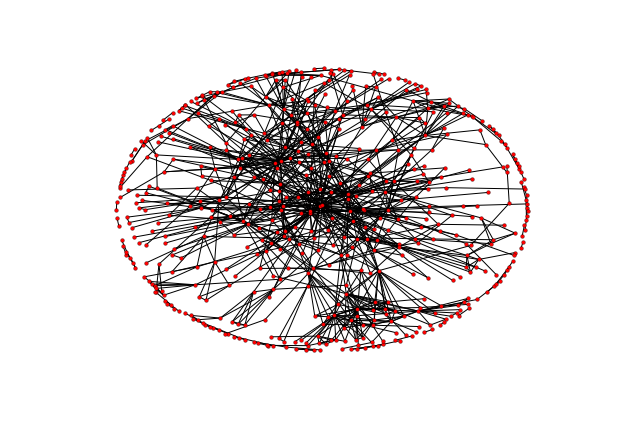

In [50]:
nx.draw_spring(G, with_labels=False, node_size=14)

### Here we display the number of sub-graphs.

In [51]:
nx.number_connected_components(G)

45

### Here we get the sub graphs

In [52]:
graphs = list(nx.connected_component_subgraphs(G))

### Here we display the number of edges in each sub-graph. Notice that the 2nd sub-graph (index 1) has many more edges. This is the one that is of most interest. We will analyze this subgraph. The other graphs have very few edges (less than 3).

In [53]:
for graph in graphs:
    print(graph.number_of_edges())

1
1011
2
1
1
1
5
2
1
3
1
1
1
1
3
1
1
3
3
3
1
2
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


### We will now output the diameter for each sub-graph. Note that the he 2nd sub-graph (index 1) has the largest diameter.  This confirms that the 2nd sub-graph is the one that is most connected.

In [54]:
for i in range(0,len(graphs)):
    print nx.diameter(graphs[i]) 

1
12
2
1
1
1
2
2
1
1
1
1
1
1
1
1
1
3
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


### We will now display some of the edges of the 2nd sub-graph in the list. 

In [55]:
graphs[1].edges()[0:10]

[('Michigan Technological University', 'Shenzhen University'),
 ('Michigan Technological University', 'Gautam Buddha University'),
 ('Michigan Technological University', 'Henan Agricultural University'),
 ('Tokushima University Graduate School', 'Osaka University'),
 ('Tokushima University Graduate School',
  'Graduate School of Frontier Biosciences'),
 ('Tokushima University Graduate School', 'Nihon University'),
 ('Tokushima University Graduate School', 'Tokushima University'),
 ('Dankook University', 'National Institutes of Health'),
 ('The University of Georgia', 'Vanderbilt University'),
 ('Nagasaki University', 'The University of Tokyo')]

### We will now draw the 2nd sub-graph (index 1 in python). This looks very well connected.

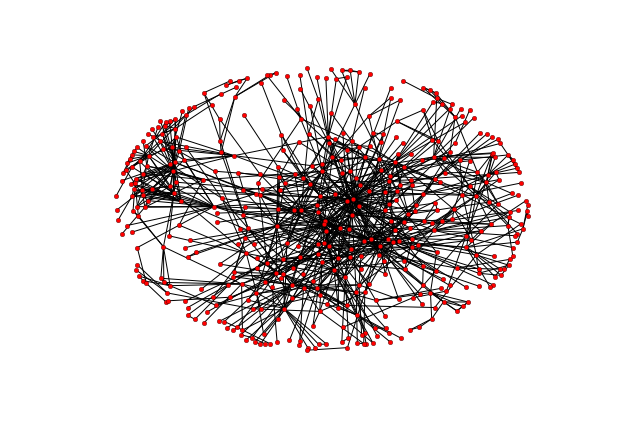

In [56]:
nx.draw_spring(graphs[1], with_labels=False, node_size=21)

### We will be calculating a few metrics on the graph: Diameter, Eccentricity and Closeness centrality.  The diameter of a graph is the length of the longest chain you are forced to use to get from one vertex to another in that graph.

### The maximum distance between a vertex to all other vertices is considered as the eccentricity of vertex.  From the Histogram below we can observe that the  eccentricity values are approximately normally distributed. This is in line with what we could expect in real-life connections.

[<matplotlib.text.Text at 0x1f7cbe48>, <matplotlib.text.Text at 0x1f7d43c8>]

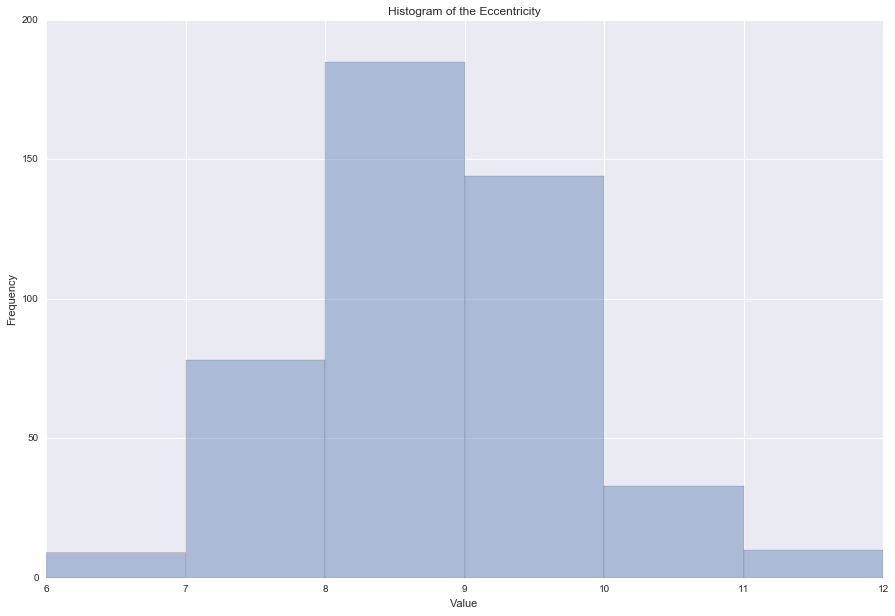

In [57]:
plt.figure(figsize = (15,10))
eccentricity = nx.eccentricity(graphs[1])
sns_bar1 = sns.distplot(eccentricity.values(), kde = False, bins = 6)
sns_bar1.set_title("Histogram of the Eccentricity")
sns_bar1.set(xlabel = "Value", ylabel = "Frequency")

### Closeness centrality is defined as the inverse of farness, which in turn, is the sum of distances to all other nodes.  We can see that the centrality measure is also normally distributed.

[<matplotlib.text.Text at 0x1f7b3278>, <matplotlib.text.Text at 0x1f7cbe80>]

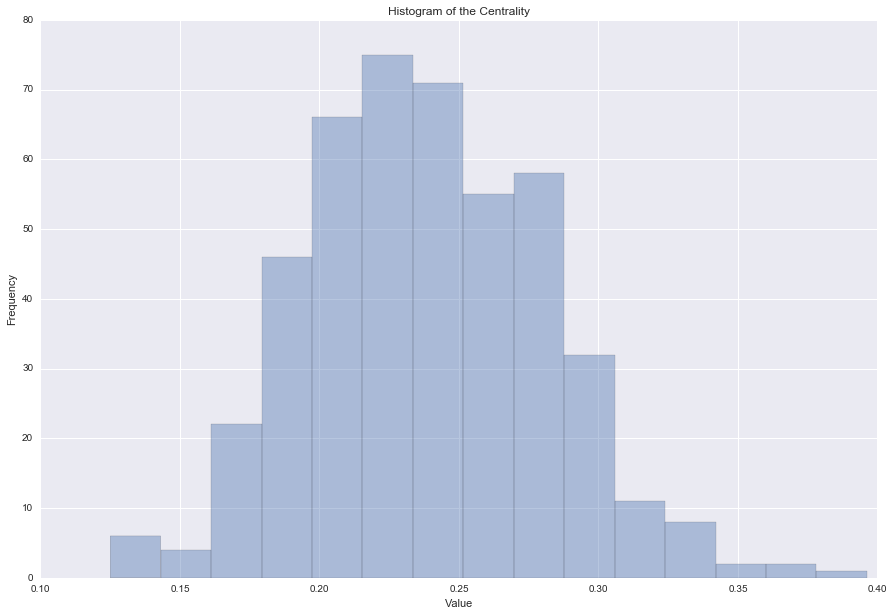

In [58]:
plt.figure(figsize = (15,10))
close_cent = nx.closeness_centrality(graphs[1])
sns_bar1 = sns.distplot(close_cent.values(), kde = False, bins = 15)
sns_bar1.set_title("Histogram of the Centrality")
sns_bar1.set(xlabel = "Value", ylabel = "Frequency")

### We plot the number of nodes as a function of degree. The node degree is the number of edges adjacent to that node.  We see that the number of nodes decreases rapidly as the degree increases.  The nodes are fairly well dispersed.  So there is fairly well distributed connectivity between the institutions.

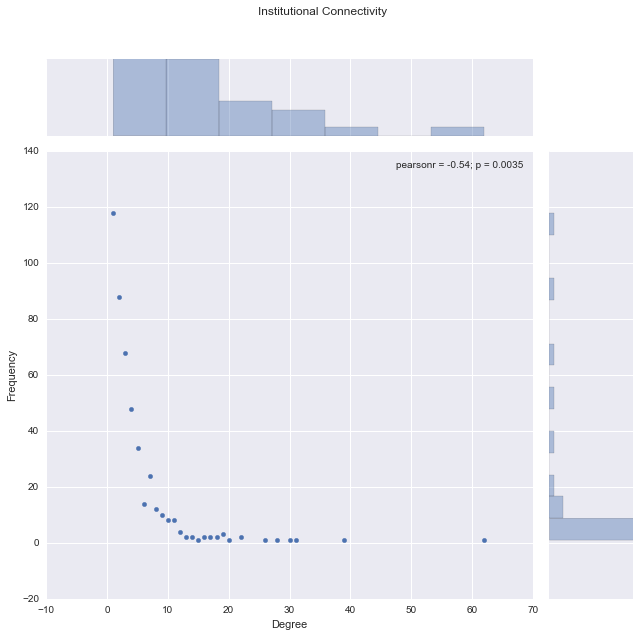

In [59]:
degrees = graphs[1].degree()
values = sorted(set(degrees.values()))
hist = [degrees.values().count(x) for x in values]
dat = pd.DataFrame()
dat['Degree'] = values
dat['Frequency'] = hist
sns_bar2 = sns.jointplot(data = dat, x = "Degree", y = "Frequency", size = 9)
plt.subplots_adjust(top=0.9)
sns_bar2.fig.suptitle('Institutional Connectivity')